# Calculate robusteness from pi control runs

In [366]:
# Some definitions

# directory of data
#fdir = '~/Google Drive/professional/research/FARALLON_INSTITUTE_PROJECTS/2020 NOAA MAPP/Climate_extremes_sharedfigsandcode/data/FOR SCATTER PLOT/'
fdir = '/Volumes/GoogleDrive/My Drive/Climate_extremes_sharedfigsandcode/data/Annual_TimeSeries/'

In [367]:
# Modules
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore') #filter some warning messages
import seaborn as sns

In [368]:
def num_coevents(y1, y2, pct1, pct2, runs='picontrol',loc='cclme'):
    # 
    fin1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fin2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fin1)
    modsst.close()
    modsm2 = xr.open_dataset(fin2)
    modsm2.close()
    
    models = modsm2.model

    # selec periood
    modsst = modsst.sel(year=slice(y1,y2))
    #modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    modsm2 = modsm2.sel(year=slice(y1,y2))

    
    drt_a = list()
    mhw_a = list()
    #drt = list()
    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1= modsst.sel(model=i).sst.values - modsst.sel(model=i).sst.mean().values
        tmp2= modsm2.sel(model=i).sm.values - modsm2.sel(model=i).sm.mean().values
    
        # calculate threshold
        mhw_thr = np.nanpercentile(tmp1,pct1)
        drg_thr = np.nanpercentile(tmp2,pct2)
    
        a1 = tmp1>=mhw_thr
        a2 = tmp2<=drg_thr
        #print(tmp1.shape,tmp1[a2],tmp2.shape,tmp2[a2])
        tmp_m = np.full((len(modsst.year.values),1),np.nan)
        tmp_m[0:len(tmp1[a2]),0]=tmp1[a2]
        
        tmp_d = np.full((len(modsst.year.values),1),np.nan)
        tmp_d[0:len(tmp2[a2]),0]=tmp2[a2]
        
        mhw_a.append(tmp_m)
        drt_a.append(tmp_d)
        
    return mhw_a, drt_a 

In [369]:
ny = 30
prc1 = 90
prc2 = 10
loc='cclme'
pi_m_a=list()
pi_d_a=list()

for i in range(int(500/ny)):
    mhw_a, drt_a  = num_coevents(i*ny+1, (i+1)*ny, prc1 , prc2, loc=loc)
    pi_m_a.append(mhw_a)
    pi_d_a.append(drt_a)

In [370]:
np.mean(np.array(pi_m_a),axis=(1)).shape #mme
np.mean(np.array(pi_m_a),axis=(0)).shape #model

(22, 30, 1)

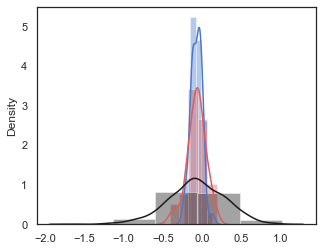

In [371]:
np.array(pi_m_a[0])

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
fig, ax1 = plt.subplots(figsize=(5,4))

ax1=sns.distplot(np.mean(np.array(pi_m_a),axis=(1)), bins=5,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,

ax1=sns.distplot(np.mean(np.array(pi_m_a),axis=(0)), bins=5,hist=True, color='r',label='PI')  #, ax=axes[0, 0])hist=False,

ax1=sns.distplot(pi_m_a, bins=5,hist=True, color='k',label='PI')  #, ax=axes[0, 0])hist=False,


plt.show()

In [372]:
## Calculate thresholds for PI Control runs

In [373]:
def get_thre(loc,y1,y2,prc1,prc2):
    # open data: anomalies (without trend)

    modsst = xr.open_dataset(fdir+'original ts/picontrol_'+loc+'_sst.nc')
    modsst.close()
    modsm2 = xr.open_dataset(fdir+'original ts/picontrol_sm.nc')
    modsm2.close()

    # select period 
    modsst = modsst.sel(year=slice(y1,y2))
    #modsm2 = modsm2.sel(year=slice(y1-1,y2-1))
    modsm2 = modsm2.sel(year=slice(y1,y2))


    mhw_thr = list()
    drg_thr = list()
    models = list()
    mean1 = list()
    mean2 = list()
    

    # Calculate thresholds for each model
    for ix,i in enumerate(modsm2.model.values):
        tmp1= modsst.sel(model=i).sst.values - modsst.sel(model=i).sst.mean().values
        tmp2= modsm2.sel(model=i).sm.values - modsm2.sel(model=i).sm.mean().values
        mean_tmp1=modsst.sel(model=i).sst.mean().values
        mean_tmp2=modsm2.sel(model=i).sm.mean().values
        mhw_thr.append(np.nanpercentile(tmp1,prc1))
        drg_thr.append(np.nanpercentile(tmp2,prc2))
        mean1.append(mean_tmp1)
        mean2.append(mean_tmp2)
        models.append(i)
    
    return mhw_thr, drg_thr , models,mean1,mean2 

In [374]:
# calculate number of events for control, historical and future
# based on pi control thresholds

def freq_coevents(fdir, runs,loc, mhw_thr, drg_thr, models,mean1,mean2, y1, y2):
    #pi control
    fi1 = fdir+'original ts/'+runs+'_'+loc+'_sst.nc'
    fi2 = fdir+'original ts/'+runs+'_sm.nc'
    modsst = xr.open_dataset(fi1)
    modsst.close()
    modsm2 = xr.open_dataset(fi2)
    modsm2.close()
    models=modsm2.model

    # select period
    modsst = modsst.sel(year=slice(y1,y2))
    modsm2 = modsm2.sel(year=slice(y1,y2))

    drt_a = list()
    mhw_a = list()

    for ix,i in enumerate(models):
        #print(ix,i)
        tmp1= modsst.sel(model=i).sst.values - mean1[ix]
        tmp2= modsm2.sel(model=i).sm.values - mean2[ix]
         
        a1 = tmp1>=mhw_thr[ix]
        a2 = tmp2<=drg_thr[ix]
        
        tmp_m = np.full((len(modsst.year.values),1),np.nan)
        tmp_m[0:len(tmp1[a2]),0]=tmp1[a2]
        
        tmp_d = np.full((len(modsst.year.values),1),np.nan)
        tmp_d[0:len(tmp2[a2]),0]=tmp2[a2]
        
        mhw_a.append(tmp_m)
        drt_a.append(tmp_d)

    
    return mhw_a, drt_a #mean no. of events

In [375]:
def freq_difruns(loc, ny, y0,y,prc1, prc2):
    
    # calculate threshold in pi control
    #y2=2014
    #y1=y2-ny+1
    mhw_thr, drg_thr, models ,mean1,mean2= get_thre(loc,y0,y,prc1,prc2)

    print ('Percentiles: '+str(prc1)+'/'+str(prc2))
    # pi control
    print('piControl: '+str(y0)+'-'+str(y))
    #y2=2014
    #y1=y2-ny+1
    mhw_a0, drt_a0 = freq_coevents(fdir,'picontrol',loc,mhw_thr,drg_thr, models,mean1,mean2,y0,y)

     # future
    y2=2099
    y1=y2-ny+1
    print('\nfuture: '+str(y1)+'-'+str(y2))
    mhw_a2, drt_a2 = freq_coevents(fdir,'ssp585',loc,mhw_thr,drg_thr, models,mean1,mean2, y1,y2)

    
    return mhw_a0, drt_a0, mhw_a2, drt_a2

In [376]:
# Frequency of events - detrended data, using pi control threshols
## percentiles 90-10

In [377]:

print ('\nPercentiles: '+str(prc1)+'/'+str(prc2))
print('\nProbable # events in '+str(ny)+' years'+': '+str(ny*0.01))


test_m_a=list()
test_d_a=list()
fu_m_a=list()
fu_d_a=list()

for i in range(int(500/ny)):
    mhw_a0, drt_a0, mhw_a2, drt_a2 = freq_difruns(loc,ny,i*ny+1, (i+1)*ny, prc1, prc2)
    test_m_a.append(mhw_a0)
    test_d_a.append(drt_a0)
    fu_m_a.append(mhw_a2)
    fu_d_a.append(drt_a2)


Percentiles: 90/10

Probable # events in 30 years: 0.3
Percentiles: 90/10
piControl: 1-30

future: 2070-2099
Percentiles: 90/10
piControl: 31-60

future: 2070-2099
Percentiles: 90/10
piControl: 61-90

future: 2070-2099
Percentiles: 90/10
piControl: 91-120

future: 2070-2099
Percentiles: 90/10
piControl: 121-150

future: 2070-2099
Percentiles: 90/10
piControl: 151-180

future: 2070-2099
Percentiles: 90/10
piControl: 181-210

future: 2070-2099
Percentiles: 90/10
piControl: 211-240

future: 2070-2099
Percentiles: 90/10
piControl: 241-270

future: 2070-2099
Percentiles: 90/10
piControl: 271-300

future: 2070-2099
Percentiles: 90/10
piControl: 301-330

future: 2070-2099
Percentiles: 90/10
piControl: 331-360

future: 2070-2099
Percentiles: 90/10
piControl: 361-390

future: 2070-2099
Percentiles: 90/10
piControl: 391-420

future: 2070-2099
Percentiles: 90/10
piControl: 421-450

future: 2070-2099
Percentiles: 90/10
piControl: 451-480

future: 2070-2099


In [378]:
#np.mean(np.array(fu_m_a),axis=(1)).shape #mme
#np.mean(np.array(fu_m_a),axis=(0)).shape #model
np.array(fu_d_a).shape
DS=np.nanmean(np.array(pi_m_a),axis=1)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
max(DS.flatten()),min(DS.flatten())

(0.13063900940345902, -0.2280309048565953)

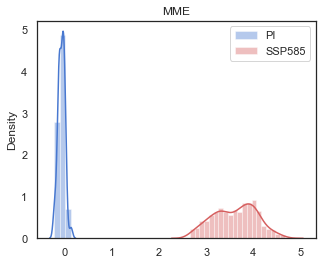

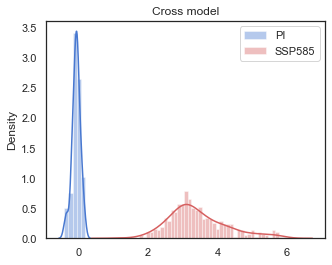

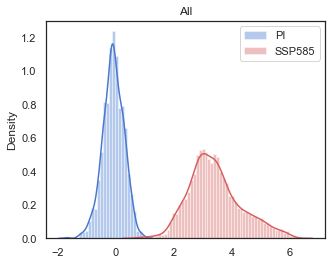

In [379]:
np.array(pi_m_a[0])

import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True)
bw=0.1

fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.nanmean(np.array(pi_m_a),axis=1)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(pi_m_a),axis=1), bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.nanmean(np.array(fu_m_a),axis=1)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(fu_m_a),axis=1), bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,
plt.title('MME')
plt.legend()
plt.show()

fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.nanmean(np.array(pi_m_a),axis=0)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(pi_m_a),axis=0), bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.nanmean(np.array(fu_m_a),axis=0)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(np.nanmean(np.array(fu_m_a),axis=0), bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,
plt.title('Cross model')
plt.legend()
plt.show()


fig, ax1 = plt.subplots(figsize=(5,4))
DS=np.array(pi_m_a)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(pi_m_a, bins=nbin,hist=True, color='b',label='PI')  #, ax=axes[0, 0])hist=False,
DS=np.array(fu_m_a)
nbin=int((max(DS.flatten())-min(DS.flatten()))/bw)
ax1=sns.distplot(fu_m_a, bins=nbin,hist=True, color='r',label='SSP585')  #, ax=axes[0, 0])hist=False,                
plt.title('All')
plt.legend()
plt.show()

In [380]:
anom=[np.asarray(pi_m_a),np.asarray(pi_d_a),np.asarray(fu_m_a),np.asarray(fu_d_a)]
np.save(loc+'_ca_with_trend_anom.npy',anom)